# Image conversion

In [ ]:
import os
import glob
import cv2
from matplotlib import pyplot as plt

def read_dataset(directory_path, grayscale):
  dataset = []
  for filename in glob.glob(os.path.join(directory_path, '*')):
      dataset.append([cv2.imread(filename), filename])
      print(filename)
  return dataset

def read_dataset_gray(directory_path):
  dataset = []
# Traverse the directory and store png images and theri file paths in a list
  for filename in glob.glob(os.path.join(directory_path, '*')):
      dataset.append([cv2.imread(filename,  cv2.IMREAD_GRAYSCALE), filename])
      print(filename)
  return dataset

# Binarize images
# useful resource: https://medium.com/analytics-vidhya/enhance-a-document-scan-using-python-and-opencv-9934a0c2da3d
def resize_receipt(src_dir,dest_dir):
    for filename in glob.glob(os.path.join(src_dir, '*')):
        img = cv2.imread(filename)
        resized = opencv_resize(img, 0.3)
        cv2.imwrite(dest_dir + os.path.basename(filename), resized)
        count += 1
    print(count)
def binarize_receipts(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        if filename.endswith('png'):
            print(filename)
            purename= os.path.splitext(os.path.basename(filename))[0]
            extension = os.path.splitext(os.path.basename(filename))[1]
            img = cv2.imread(src_dir + filename)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #         Thresholding image with based on local values
            binary = cv2.adaptiveThreshold(gray.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,21,13)
            cv2.imwrite(dest_dir + purename+extension, binary)

def tesseract_receipts(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        if filename.endswith('png'):
            print(filename)
            purename= os.path.splitext(os.path.basename(filename))[0]
            img = cv2.imread(src_dir + filename)
            extracted_text = pytesseract.image_to_string(img, lang='slv', config='--psm 4')
            # print(extracted_text)
            with open(dest_dir + purename+'.txt', 'w') as file:
                file.write(extracted_text)

In [ ]:
!pip install openai

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git




  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
print(len(dataset))

25


In [ ]:
import re
import json
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
# Recognase a receipt and return json
def DONUT(image):
  processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
  model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)
  # load document image
  #dataset = load_dataset("hf-internal-testing/example-documents", split="test")
  #image = dataset[2]["image"]

  # prepare decoder inputs
  task_prompt = "<s_cord-v2>"
  decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
  pixel_values = processor(image, return_tensors="pt").pixel_values

  outputs = model.generate(
      pixel_values.to(device),
      decoder_input_ids=decoder_input_ids.to(device),
      max_length=model.decoder.config.max_position_embeddings,
      pad_token_id=processor.tokenizer.pad_token_id,
      eos_token_id=processor.tokenizer.eos_token_id,
      use_cache=True,
      bad_words_ids=[[processor.tokenizer.unk_token_id]],
      return_dict_in_generate=True,
  )

  sequence = processor.batch_decode(outputs.sequences)[0]
  sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
  return processor.token2json(sequence)
  # with open(filename, 'w') as file:
  #   file.write(processor.token2json(sequence))

def json2file(jsonarray,filename):
  json_data = json.dumps(jsonarray, indent=2)
  with open(filename, 'w') as file:
    file.write(json_data)

## DONUT receipt OCR


In [ ]:
#recognize a receipt and save it in the same location as the image, but with .txt extension
directory_path = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/resized'
datset = read_dataset(directory_path)
for item in dataset:
  json_receipt = DONUT(item[0])
  print(json_receipt)
  json2file(json_receipt, os.path.splitext(item[1])[0] + '.txt')


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


{'menu': [{'nm': 'Cest tv Trinovle 10a. 3000 Celie', 'discountprice': 'S187927497', 'price': 'd.o.o.'}, {'nm': 'Tusupemarket Kozina', 'unitprice': '16,6240', 'cnt': 'B', 'price': {'num': 'Tel.0801310', 'discountprice': '1,99'}}, {'nm': 'P. BRIS.BELLI', 'unitprice': '1,87', 'cnt': '8', 'discountprice': '3,19', 'price': '1,97'}, {'nm': 'Prihranek ackja', 'unitprice': '(25,00%)', 'cnt': {'unitprice': '1,58'}, 'discountprice': '1,58', 'price': '1,58'}, {'nm': 'BISKVIT JAFFA D U U', 'discountprice': '1,09', 'price': '1,09'}, {'nm': 'PIKOKOTT ORE R 1', 'discountprice': '1,450)', 'price': '1,59'}, {'nm': 'Prinshake akeuja', 'unitprice': '(0,406)', 'cnt': 'B', 'price': '1,59'}, {'nm': 'NAMAZ HUNUS頁面', 'unitprice': '1,64', 'cnt': 'B', 'discountprice': '( )', 'price': '1,64'}, {'nm': 'NAMAZ HUNUS KBI', 'unitprice': '( )', 'cnt': 'B', 'price': '1,64'}, {'nm': 'NAMAZ HUNUS KBI', 'unitprice': '( )', 'cnt': 'B', 'price': '1,64'}, {'nm': 'NAMAZAN', 'unitprice': '( )', 'cnt': 'B', 'price': '1,64'}, {'

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[{'nm': 'Izdelek Kolicina Cena Znesek', 'unitprice': '1,99', 'cnt': '1', 'price': '1,99'}, {'nm': 'NAPOLIT. FRONDI M 1', 'unitprice': '(0,30 )', 'cnt': '1', 'price': '1,94'}, {'nm': 'Prihranek M10', 'unitprice': '(0,30 )', 'cnt': '1', 'price': '0,99'}, {'nm': 'C # PAP. BRIS.BELLI', 'unitprice': '1,94', 'cnt': '1', 'price': '1,97'}, {'nm': 'B # SCIT.SENTA STA', 'unitprice': '1,87', 'cnt': '1', 'price': '1,87'}, {'nm': 'CIST.TUS ZA OD 1', 'unitprice': '3,19', 'cnt': '1', 'price': '3,19'}, {'nm': 'COK.ML. DORINA', 'unitprice': '0,99', 'cnt': '1', 'price': '0,99'}, {'nm': 'B # KEKSI TARALLUC', 'unitprice': '1,71', 'cnt': '1', 'price': '1,71'}, {'nm': 'Prihranek akija (25,00%)', 'unitprice': '1,58', 'cnt': '1'}, {'nm': 'ZOB. PASTA SIGNAL', 'unitprice': '1,58', 'cnt': '1', 'price': '1,58'}, {'nm': 'Prihranek Tus Klub (1,59)', 'unitprice': '1,09', 'cnt': {'unitprice': '1'}, 'price': '1,09'}, {'nm': 'Prihranek Tus Klub (1,11e)', 'unitprice': '1,59', 'cnt': {'unitprice': '(0,40E)'}, 'price': '1

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[{'nm': 'Cest tv Trinovle 10a, 3000 Celie', 'discountprice': 'S187927497', 'price': 'd.o.o.'}, {'nm': 'Tusupemarket Kozina', 'unitprice': '16,6240', 'cnt': 'B', 'price': {'unitprice': '1,99', 'cnt': 'C'}}, {'nm': 'WWW. Lus.i facebook.com/tusslovenija', 'unitprice': '1,94', 'cnt': 'C♯<s_cnt> 8', 'discountprice': '3,19', 'price': '1,87'}, {'nm': 'KOLICina Cena', 'price': '0,99'}, {'nm': 'KEKSI TARALLUCI', 'unitprice': '1,71', 'cnt': 'B', 'discountprice': '1,71', 'price': '0,99'}, {'nm': 'Prihnanek M10 (o, 30e)', 'unitprice': '1,99', 'cnt': {'unitprice': '1,94'}, 'discountprice': '1,87', 'price': '1,94'}, {'nm': 'SCITS.SITA STA', 'unitprice': '1,87', 'cnt': {'unitprice': '0,99'}, 'price': '0,99'}, {'nm': 'KEKSI TARALLUC', 'unitprice': {'nm': 'Prihnanek ackja'}, 'cnt': [{'unitprice': '1,58', 'etc': ['1', '1', '1,58', '1,28']}, {'nm': 'BISKVIT JAFFA D U', 'unitprice': '1,09'}], 'price': '1,09'}, {'nm': 'PISKOTI ORE R', 'unitprice': '(1,11e)', 'cnt': '8', 'price': '1,59'}, {'nm': 'Prihnanek 

# TESSERACT

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-slv
!pip install pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

In [ ]:
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
def get_receipt_box(img):
  d = pytesseract.image_to_data(img, output_type=Output.DICT)
  n_boxes = len(d['text'])
  height, width = img.shape[:2]
  max_diag = 0
  (xm,ym,wm,hm) = (0,0,0,0)
  for i in range(n_boxes):
      # if int(d['conf'][i]) > -1:
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      if w^2+h^2 > max_diag and w<0.95*width:
          max_diag = w^2+h^2
          (xm,ym,wm,hm) = x, y, w, h
  return  (xm,ym,wm,hm)


In [ ]:
src_dir = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/resized/'
filename='eurospin-1.png'
img=cv2.imread(src_dir+filename)
# plt.imshow(img, cmap='Greys_r')
(xm,ym,wm,hm) =get_receipt_box(img)
img = cv2.rectangle(img, (xm, ym), (xm + wm, ym + hm), (255, 0, 0), 4)
cv2_imshow(img)

In [ ]:
src_dir = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/binarized/'
dest_dir = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/tesseract/'

tesseract_receipts(src_dir, dest_dir)


In [ ]:
from pytesseract import Output
directory_path = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/binarized/'
filename='eurospin-1.png'
img=cv2.imread(directory_path+filename)
plt.imshow(img, cmap='Greys_r')
# d = pytesseract.image_to_string(img, lang='slv', config='--psm 0',  output_type=Output.DICT)
d = pytesseract.image_to_string(img, config='--psm 0')
# d = pytesseract.image_to_string(img, lang='slv',  output_type=Output.DICT)
# print(d.keys())
# n_boxes = len(d['text'])
# for i in range(n_boxes):
#     if int(d['conf'][i]) > 60:
#         (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
#         img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# cv2.imshow('img', img)
# cv2.waitKey(0)
print(d)

In [ ]:
extracted_text = pytesseract.image_to_string(img, lang='slv', config='--psm 4')
print(extracted_text)

# OCR postprocessing

Image to text

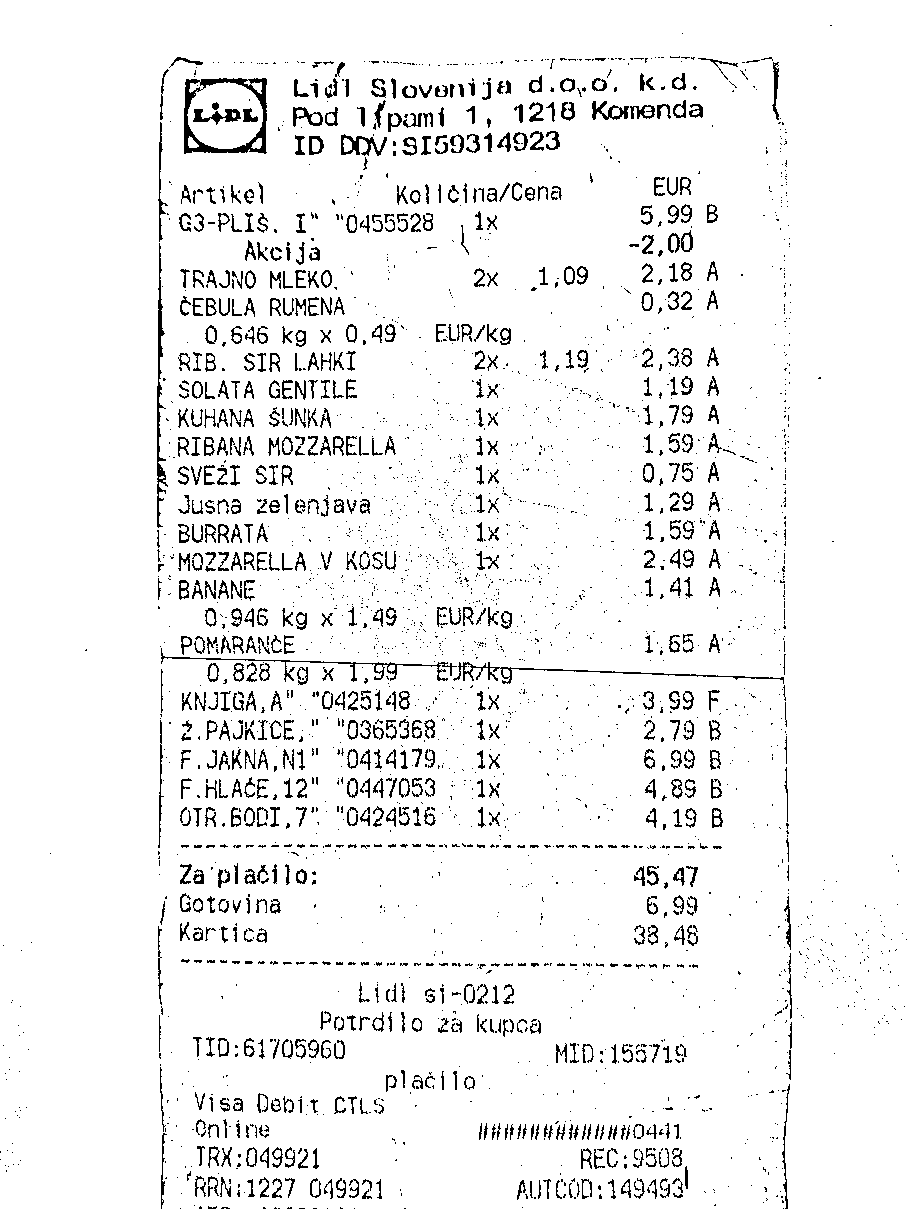

    

 

 

OT pag m oo 4yOVT]

[ PR Lidi Slovenija. d. 0,0. k. d.
[rsee]. rod 1fp ami 1, 1218 Komenda
b.l ID pov:  SI59314923 ' 5

ČArtikel v količina/Cena. ' O EVR :

V G3-PLIŠ. I" "0455528 | 1x 3,99 B

Akcija - -2,00
TRAJNO MLEKO," 2x .1;09, 2,18A -
ČEBULA RUMENA 0,32 A

0,646 kg x 0,49". EUR/kg ve.
RIB. SIR LAHKI 2x. 1,19, '2,98A

" SOLATA GENTTLE oci ne, ASA :
< KUHANA ŠUNKA orada Va STV, J9A ši
RIBANA MOZZARELLA... 1x ce:« 1, 59/A.
SVEŽI SIR (:.<. lxč 0,75A i
Jusna zelenjava ;..: 61x"... 1,29A i
BURRATA /. o" seb UUA,B9'A <<j
K MOZZARELLA. V Koli ss RO. 2,49Al,;
"BANANE RO zo OAALAJU

O0;946 kg x 1; 49 sušo NA sel

| POMARANČE ML O HeBA? Ji

0,828 kg x 1,39 PR/ky - ]

| KNJIGA,A". "0425148," 1x.'e: 253,99 Eo.

UZ PAJKICE," V O9GBJEB 1x vo 279BC.
FLJAKNA,NI" S0414179,. 1x ou 6,99 B
F.HLAČE,12" "0447058 '1x. 4, 89B

OTR.BODI,7" "0424518 1x; OC 4,19B O...

' za plačilo: : . 45,47 l

j Gotovina |» s : 6,99. ;
Kartica : 38,48 j

Lidi si-0212
Potrdito za kupca

|. TIO:61705960 MID:S871

In [ ]:
import pandas as pd
from google.colab.patches import cv2_imshow
# filename2='es_cr.png'
src_dir= '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/binarized/'
dest_dir= '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/tesseract_json/'
filenames=['dm-1.png','hofer-1.png','spar-1.png','tus-1.png','mercator-12.png','interspar-5.png','lidl-2.png']
filename=filenames[6]
img=cv2.imread(src_dir+filename)
cv2_imshow(img)
cv2.waitKey(0)
# extracted_text = pytesseract.image_to_string(img, lang='slv', config='--psm 4 -c tessedit_char_whitelist=ABCCČDEFGHIJKLMNOPQRSTUVWXYZŠTU VWXYZŽabcdefghijklmnopqrstuvwxyzžćđššž.-!#$%/_,:;')
extracted_text = pytesseract.image_to_string(img, lang='slv', config='--psm 4')
# OUTPUT AS DATAFRAME
# text = pytesseract.image_to_data(img, lang='slv', config='--psm 4', output_type='data.frame')
# text = text[text.conf != -1]
# pd.set_option('display.max_rows', None)
# display(text)
purename= filename.split('.')[0]
with open(dest_dir +purename+'.txt', 'w') as file:
                file.write(extracted_text)
# postprocessed_json_txt=ocr_receipt_to_json(extracted_text)

# Save the text data as a JSON file
# with open(dest_dir+purename+'.json', 'w', encoding='utf-8') as json_file:
#     json.dump(postprocessed_json_txt, json_file,ensure_ascii=False, indent=4)
print(extracted_text)

Print borders

In [ ]:
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
src_dir = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/binarized/'
filename='hofer-1.png'
img=cv2.imread(src_dir+filename)
d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())
n_boxes = len(d['text'])
height, width = img.shape[:2]
max_diag = 0
(xm,ym,wm,hm) = (0,0,0,0)
for i in range(n_boxes):
    # if int(d['conf'][i]) > -1:
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if w^2+h^2 > max_diag and w<0.9*width:
        max_diag = w^2+h^2
        (xm,ym,wm,hm) = x, y, w, h
img = cv2.rectangle(img, (xm, ym), (xm + wm, ym + hm), (255, 0, 0), 4)
cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
print(d['text'])

['', '', '', '', 'HOFER', 'TRGOVINA', 'D.0.0,.1D', 'za', 'pOV:S191049522', '', 'Kranjska', 'cesta', '1,', '1225', 'Lukovica', '', 'EUR', '', 'TkK:Sv.p.file', '500g', '', 'Pizza', 'burek', '220g', '', 'Pizza', 'burek', '220g', '', 'Ekstra', 'dézem', '450g', '', 'Prlesko', 'maslo', '250g', '', 'Pokovka', 'solj.', '120g', '', 'Goveji', 'zrezki', '600,', '', 'Mikro.', 'Krpa', '3/1', '', 'Bio.vr.sad.in', 'zel.', '', 'Jabo]', '.zé1.TK', 'za', 'kg', '', '0,932', 'kg', 'x', '1,59', 'EUR/Kg', '', 'Cottage', 'sir', '200g', '', 'Cottage', 'sir', '200g', '', 'Premium', 'pigkoti', '', 'Tekoce', 'milo', 'pol.', '', 'Bio.vr.sad.in', 'zel.', '', 'Korenje', 'za', 'kg', '', '0,484', 'kg', 'x', '.', '0,99', 'EUR/kg', '', 'Zob', '.past', '.Sensadyne', '', 'tesen', '150g', '', 'Narezek', 'pp', '125g', '', 'Arasidi', '300g', '', '', '', 'MAOWOUOUOUONDOwOWS', '', '', '', 'coon', 'rPrrw', 'POO', 'PS', 'Sa', 'PUN', 'rr', 'rr', 'Yr', 'r>', '', '', '', 'KOBCONHN', 'NG', '', 'HOWTUODWAGI', '', '', '', 'Oo', '', '

In [ ]:
max_diag = 0
(x,y,w,h) = (0,0,0,0)
x = 0
y = 0
for i in range(n_boxes):
    left, top, width, height = int(d['left'][i]), int(d['top'][i]), int(d['width'][i]), int(d['height'][i])
    right = left + width
    bottom = top + height


    # Update widest and highest boxes if needed
    if width^2+height^2 > max_diag:
        max_diag = width^2+height^2
        (x,y,w,h) = left, top, width, height

print("Widest box:", widest_box)
print("Highest box:", highest_box)

Widest box: 907
Highest box: 1209


In [ ]:
import os

def append_text_files(input_directory, output_file):
    # Open the output file for appending
    with open(output_file, 'a') as output_f:
        # Iterate over files in the input directory
        for filename in os.listdir(input_directory):
            # Check if the file is a text file
            if filename.endswith('.txt'):
                # Open the text file for reading
                with open(os.path.join(input_directory, filename), 'r') as input_f:
                    output_f.write('---------------------------------')
                    output_f.write(filename)
                    output_f.write('---------------------------------\n')
                    # Read the contents of the text file
                    contents = input_f.read()
                    # Append the contents to the output file
                    output_f.write(contents)
                    # Add a newline separator between files
                    output_f.write('\n')

# Example usage:
input_directory = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/tesseract/'

output_file ='/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/tesseract/alltogether.txt'

append_text_files(input_directory, output_file)


In [ ]:
import re
text='STRUČKA 3 SEMEMI 2x 0,39 O,78A'
# regex= r'[0-9oOzZil][\.,][0-9oOzZil]{2}\s?[xbABC08€£4\.]?(\s[x4z]?[\.:]?)?$'
regex= r'^([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\',]+[\.\',:]?\s?)+([0-9]+\s+)?([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\',]+[\.\',:]?\s?)*'
match= re.search(regex,text)
if(match):
 print(match.group(0))

STRUČKA 3 SEMEMI 


In [18]:
import re
# reg_ex = r'^([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\'\-,]{1,}[\.\',:]?\s?)+([0-9]+\s+)?([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\'\-,]{3,}[\.\',:]?\s?)*'
reg_ex=r'^([0-9zZDo]+[\.,][0-9zZDo]+|[0-9zZD]+)(\s?[a-z]{2,3})?'
text ='1,286 kg x 2,49 EUR/kg'
match= re.search(reg_ex,text)
if(match):
 print(match.group(0))

1,286 kg


In [ ]:
print(correct_price('0,7S'))

0.79


Receipt to JSON

In [44]:
import re
import json

def get_package_info(line):
  package_errors = [('k9',r'^\d+k9$'),
                   ('KG',r'^(\d+|\d+\.|\d+)KG$'),
                   ('G',r'^(\d+|\d+\.|\d+)G$'),
                   ('g',r'^\d{2,4}[693a]$'),
                   ('xg',r'^(\d+[xX]\d+[369a])$'),
                   ('ml',r'^\d+(m1|HL|m\])$'),
                   ('2x',r'[zZ] x'),
                   ('%m.m',r'^\d+2m.m$'),
                   ('L',r'^(\d\.\d1|\d1)$'),
                   ]
  # package_reg_ex = r'^(\d+|\d+[\.,]\d+)[0124578]$'
  package_reg_ex = r'^(\d+|\d+[\.,]\d+)'
  price_reg_ex = r'(\d[\.,]\d{2,3}\s?[xbABC08€£]?(\sx\.)?|\d{4,5}\s?[xbABC08€£\.]?(\s[x4]?[\.:]?))$'
          # print('QUANTITUY  '+quantity)
  # print(line)
  match = re.search(price_reg_ex, line)
  if match:
        line =  line[0:match.start()]
        # print('MATCH ', match.span())
  package_info_list = line.split()
  # print(package_info_list)
  quantity = ''
  if len(package_info_list) == 0:
    return ('','')
  else:
    # if firts item is a number, ignore it, otherwise it is a package info
    print('L I N E (0):' + package_info_list[0] )
    # if len(package_info_list) > 1:
    package_match = re.search(package_reg_ex, package_info_list[0])
    if not package_match:
      #  print(quantity_match.group(0))
      line = package_info_list[0]
      if len(package_info_list) > 1 and ( package_info_list[1]=='6' or
                                        package_info_list[1]=='9' or
                                          package_info_list[1]=='3' or
                                          package_info_list[1]=='a'):
        line = line + package_info_list[1]
    else:
      qunatity = package_info_list[0]
      package_info = ''
      return ('', qunatity)

    for (error,reg_ex) in package_errors:
      # print(error + ' ' +reg_ex)
      match = re.search(reg_ex, line)
      if match:
        # print(reg_ex+'>>>'+match.group(0))
        if error == 'KG':
          line = line[:match.end()-2]+ 'kg'
        elif error == 'k9':
          line = line[:match.end()-1]+ 'kg'
        elif error == 'G':
          line = line[:match.end()-1]+ 'g'
        elif error == 'g':
          number = int(line[match.start():match.end()-1])
          # print('NUMBBER = '+number)
          if  number < 100 or number % 5 == 0:
            line = line[:match.end()-1]+ 'g'
        elif error == 'xg':
          line = line[:match.end()-1]+ 'g'
          line = line.replace("X","x")
        elif error == 'ml':
          line = line[:match.end()-2]+  error
        elif error == 'L':
          line = line[:match.end()-1]+  error
        elif error == '%m.m':
          line = line[:match.end()-4]+ error
        elif error == '2x':
            line[match.start()] = '2'
        if len(package_info_list) > 1:
          quantity = package_info_list[1]
  return (line, quantity)

def get_market(line):
    markets = [('Tuš',r'Tuš|Tus|tusslovenija'),
                   ('DM',r'dm|drogerie|DM'),
                   ('Spar',r'[Ss]par'),
                   ('Eurospin',r'[Ee]urospin'),
                   ('Kompas',r'Kompas|Shop'),
                   ('Hofer',r'HOFER'),
                   ('Lidl',r'Lidl'),
                   ('Mercator',r'[Mm][se]r[ck]ator')
                   ]
    for (market,reg_ex) in markets:
      # print(market + ' ' +reg_ex)
      match = re.search(reg_ex, line)
      if match:
        # print(reg_ex +">>>"+match.group(0))
        return market
    return None

def get_price(line):
  price_errors = [
                  ('x.xx__', r'[0-9oDOzZil][\.,][0-9oODzZil]{2}(\s|\.)?[xbABC0D8€£4\.]?(\s[x4z]?[\.:]?)?$'),
                  ('xxx__', r'[0-9oODzZil]{4,5}(\s|\.)?[xbABC0D8€£4]?:?$'),
                  # ('k9', r'(\d{3}|\d[\.,]\d{2})\s?[xbABC08€]?\.?$'),
                   ]
  # print(line)
  for (error,reg_ex) in price_errors:
    # print(error + ' ' +reg_ex)
    match = re.search(reg_ex, line)
    if match:
      # print(reg_ex+'>>>'+match.group(0))
      if error == 'x.xx__':
        return line[match.start():match.start()+4]
      elif error == 'xxx__':
        return line[match.start()]+'.'+line[match.start()+1:match.start()+3]
  return ''

def is_not_blank(line):
  return len(line.strip()) > 0
def correct_price(price):
  if price:
    price = re.sub(r'[Zz]','2', price)
    price = re.sub(r'[DOo]','0', price)
    price = re.sub(r'S$','9', price)
    price = re.sub(r',','.', price)
  return price
def correct_product(item):
  if item:
    item = re.sub(r'^[ABCDE]\s((4|H|ii|ti|dt|£)\s)?','', item)
  return item
def split_item(line):
  # item_reg_ex = r'([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\',]+[\.\',:]?\s?)+'

  # item_reg_ex = r'^([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z£\.\',]{1,}[\.\',:]?\s?)+([0-9]+\s+)?([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\',]{3,}[\.\',:]?\s?)*'
  item_reg_ex = r'^([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z£\.\',]{1,}[\.\',:]?\s?)+([0-9]+\s+([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\',]{3,}[\.\',:]?\s?)+|([\u010C\u010D\u0160\u0161\u017D\u017Ea-zA-Z\.\',]{3,}[\.\',:]?\s?)*)'
  # qunatity_reg_ex = r'^(\d+|\d+[\.,]\d+)[^369]$'
  # price_reg_ex = r'(\d{3}|\d[\.,]\d{2})\s?[xbABC08€]?\.?$'\
  second_line_reg_ex=r'^([0-9zZDo]+[\.,][0-9zZDo]{2,}|[0-9zZDo]+\s?\[^0-9]|\-\d+)'
  second_line_quantity_reg_ex=r'^([0-9zZDo]+[\.,][0-9zZDo]+|[0-9zZD]+)(\s?[a-z]{2,3})?'
  product_name=''
  package_info=''
  quantity=''
  price=''
  first_line=True;
  # main_line = True
  # match item line
  # print('inside '+line)
  match = re.search(item_reg_ex, line, re.UNICODE)
  # print(match)
  if (match):
    # print('ITEM: '+match.group(0))
    product_name = match.group(0)
    rest_of_item = line[match.end():]
    (package_info, quantity)=get_package_info(rest_of_item)
      # price=get_price(rest_of_item)
    price=get_price(line)

  else:
     second_line_match = re.search(second_line_reg_ex, line)
     if second_line_match:
      # print('SECOND LINE '+line)
      first_line=False;
      quantity_match=re.search(second_line_quantity_reg_ex,line)
      if quantity_match:
        quantity = quantity_match.group(0)
        price=get_price( line[quantity_match.end():])
      # print('PRICE:'+price)
      # price_match = re.search(price_reg_ex,line)
      # if price_match:
      #   price = price_match.group(0)
    # print(product_name+'>>> '+package_info+'>>> '+quantity+'>>> '+price)
  return(correct_product(product_name),package_info,quantity,correct_price(get_price(price)),first_line)

def ocr_receipt_file_to_json(file_path):
# Define a list of known units of measurement
  with open(file_path, 'r', encoding='utf-8') as file:
      file_content = file.read()
  return  ocr_receipt_to_json(file_content)

# def process_market()
def ocr_receipt_to_json(receipt_txt):
# Define a list of known units of measurement
  item_begin_reg_ex = '([Cc]ena|Artikel|[Kk]oličina|Kol\.|Vrednost|[Zz]nesek|[Ii]zdelek|^\s*EUR\s*$)'
  item_skip_reg_ex = '(^[^0-9]+\s*:\s+|[Pp]opust|[Kk]upon|[Pp]rihranek|[Aa]kcija)'
  footer_begin_regex='(Attendant|AUtenidant|ECR|V[IT]SA|[Ss]?kupa[jJ]|[Zz]?a plačilo|[Zz]nesek|[Kk]artica|[Pp]otrdilo|[Kk]upca|Super cena|Način|Pridobili)'
  position = {
      "market": True,
      "header": False,
      "items": False,
      "footer": False
  }
  market_found=False
  json_receipt = {"market":"",
                  "items":[]}
  # print(pattern)
  json_items = []
  item_index=-1;
  lines = receipt_txt.splitlines()
  line_index=0
  # check header for market and start of items
  for line in lines:
    if is_not_blank(line):
        market=get_market(line)
        if market:
          json_receipt["market"] = market;
          break
  for line in lines:
    line_index += 1
    match = re.search(item_begin_reg_ex, line)
    if match:
      print('ITEMS:' +line)
      position["items"] = True
      position["header"] = False
      break
  if line_index == len(lines):
    line_index = 0
    position["items"] = True
# iterate through items (even if there is not math for market or items header)
  for line in lines[line_index:]:
    if is_not_blank(line):
      if position["items"]:
        # print(line)
        if re.search(item_skip_reg_ex+'|'+item_begin_reg_ex,line):
          # print('IGNORED:'+line)
          continue
        # print(line)
        (product_name,package_info,quantity,price,main_line) = split_item(line)
        matches_items = re.findall(footer_begin_regex, product_name)
        if len(matches_items) >0:
          # print(matches_items)
          position["items"] = False
          position["footer"] = True
          break
        if main_line:
          json_node = {
            "name": product_name,
            "package":package_info,
            "quantity":quantity,
            "price": price
            }
          if (product_name==''):
            continue
          json_items.append(json_node)
          item_index += 1
        else:
          json_items[item_index]["quantity"]=quantity
          if json_items[item_index]["price"] == '':
            json_items[item_index]["price"] = price
  json_receipt["items"]=json_items
  return json_receipt
dir_path = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/processed/mercator-11/'
file_name='mercator-11.txt'
receipt_txt=ocr_receipt_file_to_json(dir_path+file_name)
print(receipt_txt)
# Save the text data as a JSON file
# with open(dir_path+'hofer-1.json', 'w', encoding='utf-8') as json_file:
#     json.dump(receipt_txt, json_file,ensure_ascii=False, indent=4)


ITEMS:azi Kol. EM Vrednost
L I N E (0):2,PINK
L I N E (0):500G
L I N E (0):1006
L I N E (0):1006
L I N E (0):<
L I N E (0):)
{'market': 'Mercator', 'items': [{'name': 'PIJ.ORA GR', 'package': '', 'quantity': '2,PINK', 'price': '0.54'}, {'name': 'TIJAST SENDVIČ ILZ MERIT ', 'package': '', 'quantity': '500G', 'price': '8.35'}, {'name': 'čik HILKA LES, ZROBLJ, ', 'package': '', 'quantity': '1,49', 'price': '1.00'}, {'name': 'cik jila MLEČNA Jos', 'package': '', 'quantity': '', 'price': ''}, {'name': 'BIN. HARIBO HAPPY cia GUM. ', 'package': '', 'quantity': '1006', 'price': '1.89'}, {'name': 'BANENE ', 'package': '<', 'quantity': '', 'price': ''}]}


In [45]:
file_path = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/tesseract/hofer-1.txt'
print(ocr_receipt_to_json(file_path))

{'market': '', 'items': []}


In [46]:
import shutil
import os
def tesseract_receipts(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        if filename.endswith('png'):
            print(filename)
            purename= os.path.splitext(os.path.basename(filename))[0]
            os.makedirs(dest_dir+purename, exist_ok=True)

            img = cv2.imread(src_dir + filename)
            extracted_text = pytesseract.image_to_string(img, lang='slv', config='--psm 4')
            with open(dest_dir + purename+'/'+purename+'.txt', 'w') as file:
                file.write(extracted_text)

            postprocessed_json_txt=ocr_receipt_to_json(extracted_text)

            with open(dest_dir+purename+'/'+purename+'.json', 'w', encoding='utf-8') as json_file:
              json.dump(postprocessed_json_txt, json_file,ensure_ascii=False, indent=4)
            with open(dest_dir+purename+'/'+purename+'_validate.json', 'w', encoding='utf-8') as json_file:
              json.dump(postprocessed_json_txt, json_file,ensure_ascii=False, indent=4)

            shutil.copy(src_dir+filename,dest_dir+purename+'/'+filename)
            # print(extracted_text)

src_dir='/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/binarized/'
dest_dir='/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/processed/'
tesseract_receipts(src_dir,dest_dir)

lidl-2.png
ITEMS:ČArtikel v količina/Cena. ' O EVR :
L I N E (0):3-PLIŠ.
L I N E (0):"
L I N E (0):2x.
L I N E (0):1x
L I N E (0):(:.<.
L I N E (0):/.
L I N E (0):2,49Al,;
L I N E (0):0;946
L I N E (0):"
L I N E (0):"
L I N E (0):12"
L I N E (0):7"
L I N E (0):-0212
lidl-7.png
ITEMS:. Avajke] Kol ičina/Cena EUR
L I N E (0):8x
L I N E (0):12%
L I N E (0):"
L I N E (0):1x
L I N E (0):110,
lidl-5.png
L I N E (0):1,
L I N E (0):/Cona
L I N E (0):0,69
L I N E (0):«
L I N E (0):1,39-A
L I N E (0):"ENA
L I N E (0):2/99
L I N E (0):750
L I N E (0):1,18
L I N E (0):0,47,
L I N E (0):314
L I N E (0):>
L I N E (0):54,17
lidl-3.png
ITEMS:Artikel , koT'i ci na/Cena EUR
L I N E (0):4,9SA.
L I N E (0):1x
L I N E (0):89.A
L I N E (0):2x
lidl-8.png
ITEMS:Artikel K o Količiria/Cena EUR
L I N E (0):3-LES.GAR".
L I N E (0):"
L I N E (0):4
lidl-6.png
L I N E (0):-
L I N E (0):1,
L I N E (0):3x.
L I N E (0):1,3900
L I N E (0)::..:1X
L I N E (0):2x.
L I N E (0):«,
L I N E (0):1,59A
L I N E (0):1x
L I N E (0)

IndexError: list index out of range

In [ ]:
src_dir='/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/resized/'
dest_dir='/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/binarized/'
binarize_receipts(src_dir,dest_dir)

lidl-2.png
lidl-7.png
lidl-5.png
lidl-3.png
lidl-8.png
lidl-6.png
lidl-1.png
lidl-4.png
interspar-3.png
interspar-4.png
interspar-7.png
interspar-6.png
interspar-2.png
kompas-1.png
interspar-1.png
interspar-5.png
hofer-12.png
hofer-11.png
hofer-10.png
mercator-11.png
mercator-8.png
mercator-9.png
mercator-10.png
mercator-4.png
mercator-3.png
mercator-7.png
lidl-16.png
mercator-2.png
mercator-6.png
mercator-5.png
mercator-1.png
lidl-12.png
lidl-10.png
lidl-13.png
lidl-15.png
lidl-9.png
lidl-11.png
lidl-14.png
tus-2-part-1.png
spar-7.png
tus-1.png
spar-8.png
spar-9.png
tus-2-part-2.png
mercator-17.png
spar-4.png
spar-6.png
spar-2.png
spar-1.png
spar-5.png
spar-3.png
mercator-15.png
mercator-13.png
mercator-16.png
mercator-12.png
mercator-14.png
tus-16.png
tus-10.png
tus-13.png
tus-17.png
tus-11.png
tus-14.png
tus-12.png
tus-15.png
tus-6.png
tus-5.png
tus-9.png
tus-3-part-1.png
tus-7.png
tus-3-part-2.png
tus-4.png
tus-8.png
hofer-9.png
hofer-8.png
hofer-7.png
hofer-5.png
hofer-6.png
euros

In [ ]:

file_name = "/kaggle/input/receipt-ocr-part-1-image-segmentation-by-opencv/result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
plot_gray(image)
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_rgb(boxes)
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)



NameError: name 'cv2' is not defined

2.0

# Tesseracat & GPT

In [ ]:
from openai import OpenAI
def ask_gpt_text(extracted_text):
  client = OpenAI(api_key='sk-proj-PUnP5yS9r1elGgBB5GwwT3BlbkFJorXDtb00sLkyJN4Tj5e1')
  prompt="""Your task is to improve readibility and format the following receipt data. The initial part contains header with data of the receipt issuer.
  The second part contains rows of items organized in columns. An item in the soruce text may be presented in multiple consequent rows.  The receipt is in Slovenian language. """
  completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "system", "content":prompt},
      {"role": "user", "content": extracted_text}
    ]
  )
  return completion

In [ ]:
directory_path = '/content/drive/My Drive/FINKI/Projects/FOODITY/Receipts/resized/'
filename='es.png'
img=cv2.imread(directory_path+filename)
extracted_text = pytesseract.image_to_string(img, lang='slv', config='--psm 4')
print(extracted_text)

print('##########################################################')
gpt_response= ask_gpt_text(extracted_text)
print(gpt_response)
print(gpt_response.choices[0].message.content)

uta

% EURO %

Spin;

"a.

 

Eurospin EKO d.o.o.
Renški Podkraj 64, 5292 Renče
ID za DDV: SI33065888
PE Kozina
Bazoviška cesta 17, 6240 Kozina

ZEBRA EEA LJE JE NJE EJEJE MILICE ENE ILIČ JE AEJE RE JE KE JE IE JE REJE

Datum: 19,2,2024 Ura:11:05:16
Račun št.: 300072-3-12140

Naziv artikla Znesek

Količina Cena (EUR)

VODA GAZIR. 12x500m] 1,99 A
TEKOCI JOGURT 3,2% 1 D,99A
DETER. ZA čRNO PERIL 2,89 B
OLIVE ZELENE 565G 1,39 A
LEČA VELIKA 5009 1,29A
MINI RDEČA LEČA 500G 1,19A
FERMENTI 6X100g 1,49 A
KEKSI AMARETTI 200g 1,189A
.FLANCATI 250g 0,99 A
SIR MAASDAMER 150g 1,35 A
MORTADELA Z OLIVAMI 1,19 A
SLADKA SMETANA 250m1 1,19A
SIR MAASDAMER 2,138A

0,390 kg x 7,59 EUR/kg

##########################################################
ChatCompletion(id='chatcmpl-9H9v0MZrGDg2MdQVtXm3XknZXB7OX', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Uta\n\n--- EURO ---\n\nEurospin EKO d.o.o.\nRenški Podkraj 64, 5292 Renče\nID za DDV: SI33065888\nPE Ko

# GPT

In [ ]:
import base64
import requests

# OpenAI API Key
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def ask_gpt_image(image_path):
  api_key = "sk-proj-PUnP5yS9r1elGgBB5GwwT3BlbkFJorXDtb00sLkyJN4Tj5e1"
  # Getting the base64 string
  base64_image = encode_image(image_path)
  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4-turbo",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "Give me the entire content of recepie"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 4096
  }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  return response

In [ ]:
gpt_img_repsonse=ask_gpt_image(directory_path+filename);


In [ ]:
print(gpt_img_repsonse.json())

{'id': 'chatcmpl-9HA8hWBuYQqdZllLmy7gUMAdfF6jE', 'object': 'chat.completion', 'created': 1713877579, 'model': 'gpt-4-turbo-2024-04-09', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The image you provided displays a receipt, and here are the items listed along with their prices in Euros:\n\n- VODA GAZIR.12x500ml - 1,99\n- TEKOČI JOGURT 3,2% 1 - 0,99\n- DETER. ZA ČRNO PERIL - 2,89\n- OLIVE ZELENE 565G - 1,39\n- LEČA VELIKA 500g - 1,29\n- MINI RDEČA LEČA 500g - 1,19\n- FERMENTI 6X100g - 1,49\n- KEKSI AMARETTI 200g - 1,19\n- FLANCATI 250g - 0,99\n- SIR MAASDAMER 150g - 1,35\n- MORTADELA Z OLIVAMI - 1,19\n- SLADKA SMETANA 250ml - 1,19\n- SIR MAASDAMER - 2,13 (0,390 kg × 7,59 EUR/kg)\n\nAll entries are followed by an alphabetic character (A or B) possibly indicating the VAT or tax category.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 780, 'completion_tokens': 277, 'total_tokens': 1057}, 'system_fingerprint': 'fp_67e6987839'}


In [ ]:
print(gpt_img_repsonse['choices'][0]['message']['content'])

TypeError: 'Response' object is not subscriptable

In [ ]:
print(dir(gpt_img_repsonse))

['__attrs__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_content', '_content_consumed', '_next', 'apparent_encoding', 'close', 'connection', 'content', 'cookies', 'elapsed', 'encoding', 'headers', 'history', 'is_permanent_redirect', 'is_redirect', 'iter_content', 'iter_lines', 'json', 'links', 'next', 'ok', 'raise_for_status', 'raw', 'reason', 'request', 'status_code', 'text', 'url']
